# 2 - modéliser
---

**Imports des librairies utiles**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

**A ] une approche non supervisée : LDA**

**Imports des données**

In [2]:
lda_posts_body_feature_names = np.load("data/lda_posts_body_feature_names.npy", allow_pickle=True)
lda_posts_body_tfidf = np.load("data/lda_posts_body_tfidf.npy" , allow_pickle=True, ).item()
lda_posts_body_tf = np.load("data/lda_posts_body_tf.npy" , allow_pickle=True, ).item() 

In [3]:
lda_posts_body_tfidf 

<240397x319807 sparse matrix of type '<class 'numpy.float64'>'
	with 10368669 stored elements in Compressed Sparse Row format>

In [4]:
lda_posts_body_tf

<240397x27119 sparse matrix of type '<class 'numpy.int64'>'
	with 9892115 stored elements in Compressed Sparse Row format>

In [5]:
lda_posts_body_feature_names

array(['aa', 'aaa', 'aaaa', ..., 'zzzzzzzzz', 'zzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzz'], dtype='<U257')

**lda**

In [6]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5,random_state=11).fit(lda_posts_body_tf)

In [7]:
lda.components_[0].argsort()[::-1][:10]

array([ 6505, 23883, 11186, 16943,  2796, 23674,  4588,  3569,  7788,
       26393], dtype=int64)

In [8]:
def display_topics(lda, feature_names, nb_tag):
    for x, topic in enumerate(lda.components_):
        print("--------------------------------------------")
        print(f"Topic {x}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[::-1][:nb_tag]]))
        print("--------------------------------------------")

In [9]:
display_topics(lda, lda_posts_body_feature_names, 10)

--------------------------------------------
Topic 0:
advances benjol anonymousstate asyncopen actionerrors bekijk addlistener acute ajaxcalendar bloc
--------------------------------------------
--------------------------------------------
Topic 1:
algorhthm balmer abstractdeployermojo appendparam blegdamsvej ainfval alia blockidtoconditionlabelconverter bambam abstractautowirecapablebeanfactory
--------------------------------------------
--------------------------------------------
Topic 2:
annotaion birtreportbuilder ascreenid beginplay bitmapstream asyncopen attachpathandpropagatenotifications addstatechangelistener bahn alparam
--------------------------------------------
--------------------------------------------
Topic 3:
acute bdo authorizerequest asignment anyworkbook assemblyqualifiedname axax ascreenid assembles alparam
--------------------------------------------
--------------------------------------------
Topic 4:
birthcity blcnnpc assignes addauthor applicationsecurity

**B] une approche supervisée : Multi-label classification**

**Imports des données**

In [10]:
posts = pd.read_csv("data/multi_posts.csv")
tags = pd.read_csv("data/multi_posts_tags.csv")
multi_posts = pd.concat([posts,tags], axis=1)

In [11]:
pd.set_option('display.max_colwidth', 500)

In [12]:
multi_posts.insert(2,'body_title',posts['body']+'   '+posts['title'])
multi_posts= multi_posts.drop(['body','title'], axis=1)
# if no title and no body
multi_posts = multi_posts.dropna()

In [13]:
multi_posts.head(5)

,body_title,asp,css,database,html,iphone,java,javascript,jquery,mvc,...,net,php,python,ruby,server,sql,studio,visual,web,windows
0,absolutely positioned div containing several children one relatively positioned div use percentage based width child div collapses width ie firefox safari use pixel width works parent relatively positioned percentage width child works something missing easy fix besides pixel based width child area css specification covers width collapse percentage width child element absolutely positioned parent internet explorer,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,given datetime representing person birthday calculate age years calculate someone age based datetime type birthday,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,standard way web server able determine user timezone within web page perhaps http header part user agent string determine user timezone,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,difference math floor math truncate net difference math floor math truncate,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,expose linq query asmx web service usually business tier return typed dataset datatable serialized transport asmx linq query way populate typed dataset datatable via linq query public static mydatatable callmysproc string conn mydatabasedatacontext db new mydatabasedatacontext conn mydatatable dt new mydatatable execute sproc via linq var query dr db mysproc asenumerable select dr copy linq query resultset datatable work dt query copytodatatable return dt could put result set linq query data...,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [14]:
random_state=42
scoring='accuracy'

**Séparation du jeu de données**

In [15]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(multi_posts, random_state=random_state, test_size=0.2, shuffle=True)
validation, test = train_test_split(validation, random_state=random_state, test_size=0.5, shuffle=True)

In [16]:
X_train, y_train = train['body_title'], train.iloc[:,1:].to_numpy(copy=True, dtype='int32')
X_val, y_val = train['body_title'], train.iloc[:,1:].to_numpy(copy=True, dtype='int32')
X_test, y_test = train['body_title'], train.iloc[:,1:].to_numpy(copy=True, dtype='int32')

**Extraction de caractéristiques - tfidf - pour classification**

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf(X_train, X_val, X_test):    
    multi_tfidf_vectorizer = TfidfVectorizer(max_df= 0.5, min_df=10)
    X_train = multi_tfidf_vectorizer.fit_transform(X_train)
    X_val = multi_tfidf_vectorizer.transform(X_val)
    X_test = multi_tfidf_vectorizer.transform(X_test)
    print('X_train_tfidf shape ', X_train.shape)
    print('X_val_tfidf shape ', X_val.shape)
    print('X_test_tfidf shape ', X_test.shape)
    return X_train, X_val, X_test

In [18]:
X_train_tfidf, X_val_tfidf, X_test_tfidf = tfidf(X_train, X_val, X_test)

X_train_tfidf shape  (114670, 17452)
X_val_tfidf shape  (114670, 17452)
X_test_tfidf shape  (114670, 17452)


**Transformation : encodage des catégories et mise à l'échelle des valeurs numériques**

In [19]:
"""from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train_tfidf)

X_train_tfidf_scaled = scaler.transform(X_train_tfidf)
X_val_tfidf_scaled = scaler.transform(X_val_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)"""

'from sklearn import preprocessing\n\nscaler = preprocessing.StandardScaler().fit(X_train_tfidf)\n\nX_train_tfidf_scaled = scaler.transform(X_train_tfidf)\nX_val_tfidf_scaled = scaler.transform(X_val_tfidf)\nX_test_tfidf_scaled = scaler.transform(X_test_tfidf)'

**Modélisation et optimisation principale**   
Mise en place de la validation croisée et d'une méthode d'optimisation à l'aide d'une grille paramétrable

In [21]:
from sklearn.utils.multiclass import is_multilabel

print(is_multilabel(y_train))

True


**fonction rapport classification**

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import jaccard_score

def get_metrics(y_true, y_pred, index , decimals=3):
    
    dict_metrics = {}
    dict_metrics['accuracy'] = accuracy_score(y_true, y_pred)
    dict_metrics['jaccard'] = jaccard_score(y_true, y_pred, average='weighted')
    dict_metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted')
    dict_metrics['precision'] = average_precision_score(y_true, y_pred, average='weighted')
    dict_metrics['recall'] = recall_score(y_true, y_pred, average='weighted')
    dict_metrics['recall'] = roc_auc_score(y_true, y_pred)

    metrics = pd.DataFrame(dict_metrics, index=[index])
    
    return metrics.round(decimals)

In [23]:
#init le rapport
classification_report = pd.DataFrame()

**0) classification baseline**

In [24]:
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier

dummy_classifier = DummyClassifier(strategy="stratified")
dummy_classifier = MultiOutputClassifier(dummy_classifier).fit(X_train_tfidf, y_train)

In [25]:
y_pred_train = dummy_classifier.predict(X_train_tfidf)
classification_report = classification_report.append(get_metrics(y_train, y_pred_train, 'dummy_classifier_on_train'))

In [26]:
y_pred_val = dummy_classifier.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_pred_val, 'dummy_classifier_on_val'))

**1) classification logistic regression**

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

logistic_regression = LogisticRegression()
logistic_regression = MultiOutputClassifier(logistic_regression)

n_C = 20
estimator__C = np.logspace(-2, 2, n_C)
n_jobs=[4]
estimator__max_iter = [500]

hyperparameters = dict(estimator__max_iter = estimator__max_iter,
                       estimator__C = estimator__C,
                       n_jobs = n_jobs
                      )

gscv_logistic_regression = GridSearchCV(logistic_regression, hyperparameters, cv=KFold(5,shuffle=True, random_state=random_state), scoring=scoring)
gscv_logistic_regression.fit(X_train_tfidf, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=MultiOutputClassifier(estimator=LogisticRegression()),
             param_grid={'estimator__C': array([1.00000000e-03, 1.12332403e-03, 1.26185688e-03, 1.41747416e-03,
       1.59228279e-03, 1.78864953e-03, 2.00923300e-03, 2.25701972e-03,
       2.53536449e-03, 2.84803587e-03, 3.19926714e-03, 3.59381366e-03,
       4.0370172...
       1.09749877e+01, 1.23284674e+01, 1.38488637e+01, 1.55567614e+01,
       1.74752840e+01, 1.96304065e+01, 2.20513074e+01, 2.47707636e+01,
       2.78255940e+01, 3.12571585e+01, 3.51119173e+01, 3.94420606e+01,
       4.43062146e+01, 4.97702356e+01, 5.59081018e+01, 6.28029144e+01,
       7.05480231e+01, 7.92482898e+01, 8.90215085e+01, 1.00000000e+02]),
                         'estimator__max_iter': [500], 'n_jobs': [4]},
             scoring='accuracy')

In [30]:
y_pred_train = gscv_logistic_regression.predict(X_train_tfidf)
classification_report = classification_report.append(get_metrics(y_train, y_pred_train, 'logistic_regression_on_train'))

In [31]:
y_pred_val = gscv_logistic_regression.predict(X_val_tfidf)
classification_report = classification_report.append(get_metrics(y_val, y_pred_val, 'logistic_regression_on_val'))

**matrice de confusion**

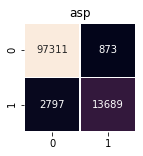

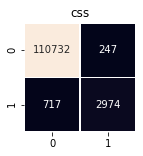

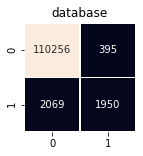

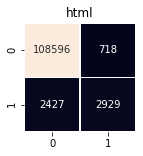

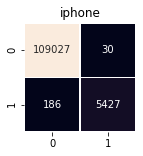

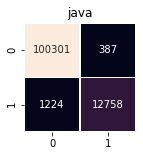

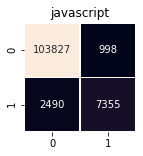

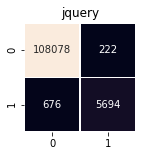

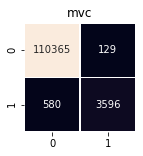

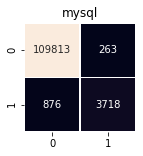

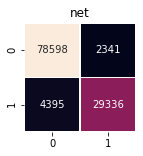

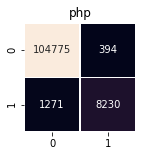

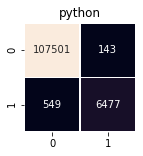

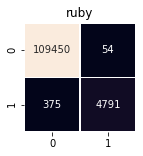

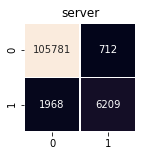

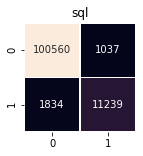

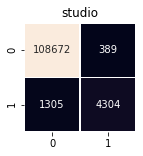

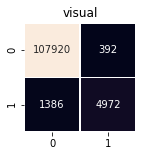

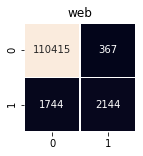

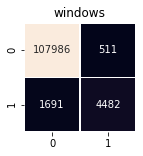

In [33]:
from sklearn.metrics import multilabel_confusion_matrix

ml_confusion_matrix = multilabel_confusion_matrix(y_train, y_pred_train)

for i, label in enumerate(tags.columns.tolist()):
    fig, ax = plt.subplots(figsize=(2,2))
    plt.title(label)
    sns.heatmap(ml_confusion_matrix[i],annot=True, cbar=None,linewidths=.5, fmt="d")

**courbe ROC pour chaques étiquettes**

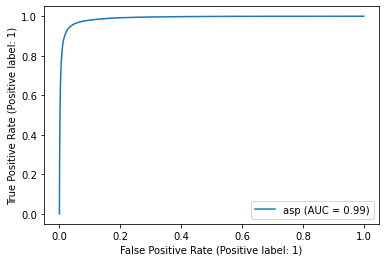

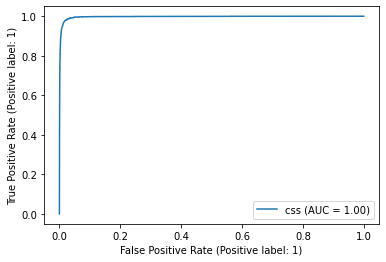

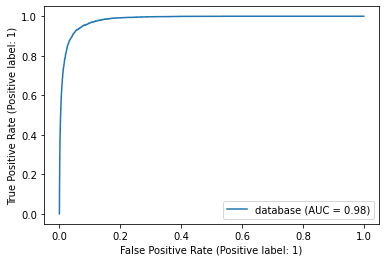

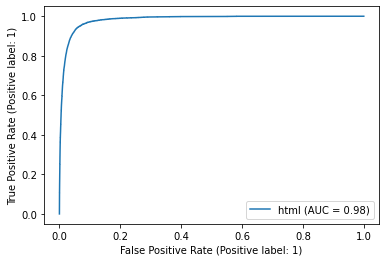

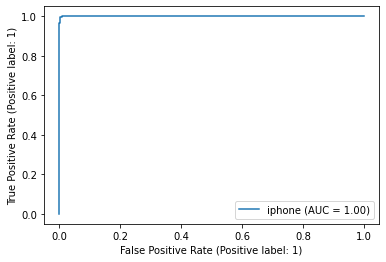

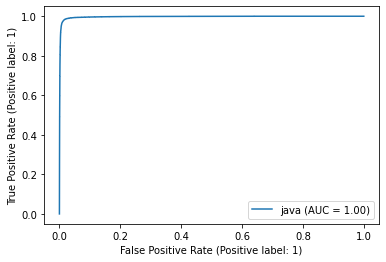

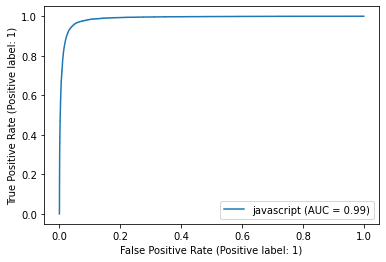

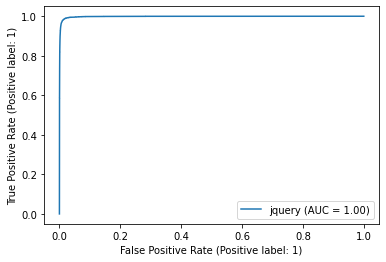

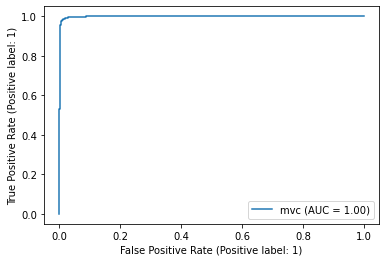

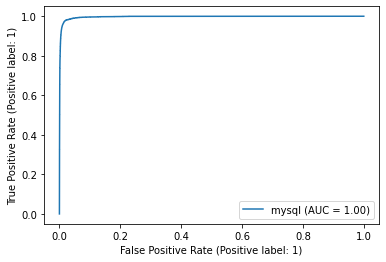

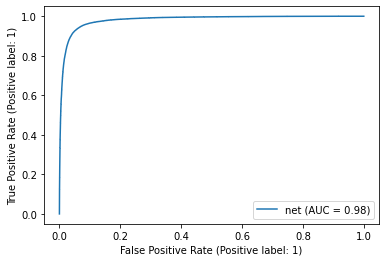

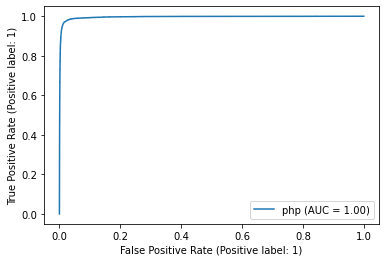

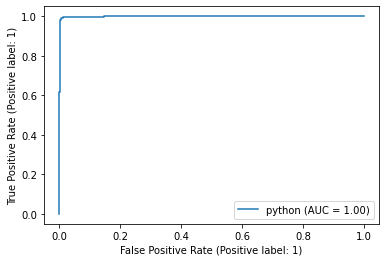

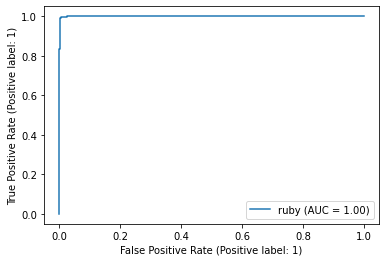

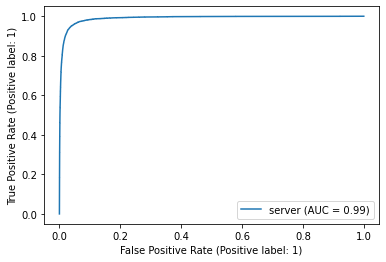

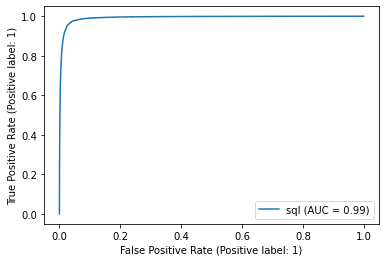

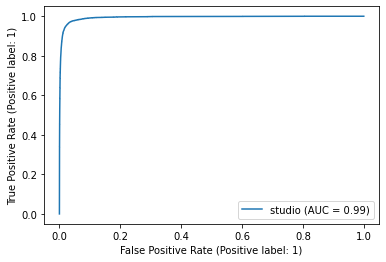

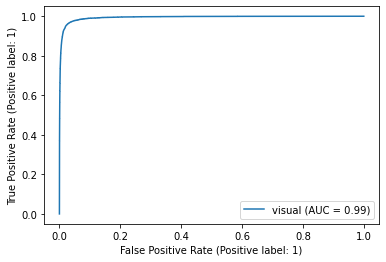

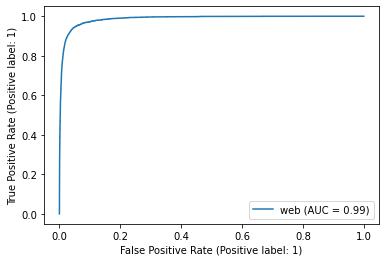

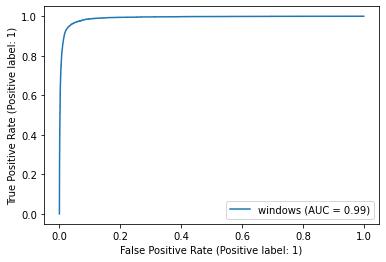

In [71]:
from sklearn.metrics import plot_roc_curve

plt.rcParams.update({'figure.max_open_warning': 0})

for i, label in enumerate(tags.columns.tolist()):
        plot_roc_curve(gscv_logistic_regression.best_estimator_.estimators_[i], X_val_tfidf, y_val[:,i].T, name=label)  

**Rapport de Classification**

<AxesSubplot:title={'center':'Train - Rapport de classification'}>

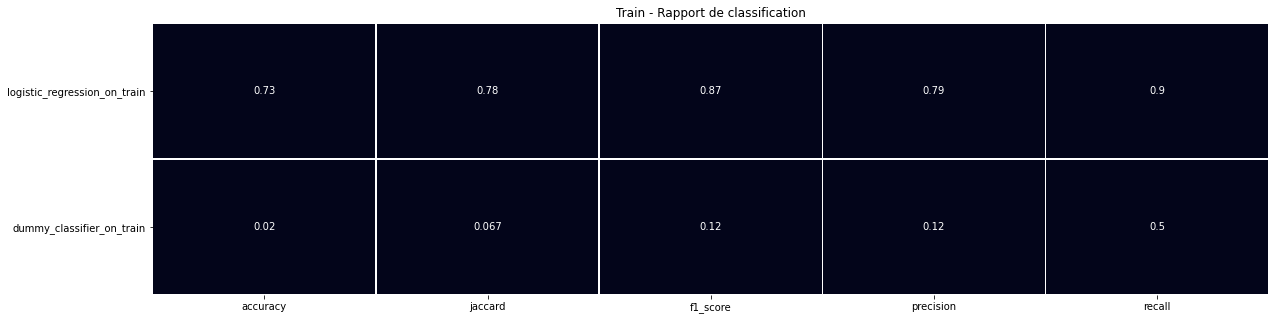

In [35]:
cr = classification_report[classification_report.index.str.contains('train$')].sort_values(by=['accuracy'], ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
plt.title('Train - Rapport de classification')
sns.heatmap(cr, vmin=classification_report.max().max(), vmax=classification_report.max().max(), annot=True, cbar=None,linewidths=.5)

<AxesSubplot:title={'center':'Val - Rapport de classification'}>

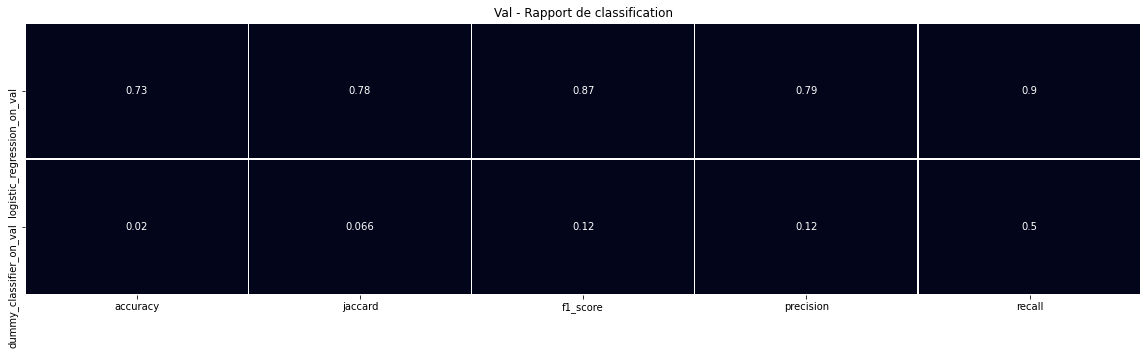

In [34]:
cr = classification_report[classification_report.index.str.contains('val$')].sort_values(by=['accuracy'], ascending=False)

fig, ax = plt.subplots(figsize=(20,5))
plt.title('Val - Rapport de classification')
sns.heatmap(cr, vmin=classification_report.max().max(), vmax=classification_report.max().max(), annot=True, cbar=None,linewidths=.5)

**fonction pour api prediction**

In [ ]:
# retourne les étiquettes pour les predictions
def labels(predictions, labels):
    preds = []
    for prediction in predictions:
        pred = []
        for i, is_label in enumerate(prediction):
            if is_label == 0:
                pass
            else :
                pred.append(labels[i])
        preds.append(pred)
    return preds
        
labels(y_train_predicted, labels=tags.columns.tolist())

In [56]:
jaccard_score(np.array([[0, 1, 1], [1, 1,0]]), np.array([[0, 1,0], [1, 0,0]]), average='samples')

0.5